In [2]:
import sys
sys.path.append('/Users/vdk/GeneveWork/Code/calibpipe-main-calibpipe/')
from astropy.io import ascii
import numpy as np
import pandas as pd
import matplotlib
import csv
import scipy
import matplotlib.pyplot as plt
from seaborn import histplot
import random
import copy
from os import path, makedirs
from astropy.coordinates import SkyCoord
from astropy.table import Table
import astropy.units as u
from ctapipe.containers import MuonEfficiencyContainer
from ctapipe.coordinates import CameraFrame, TelescopeFrame
from ctapipe.io import EventSource, EventSeeker
from ctapipe.core import TelescopeComponent
from ctapipe.core.traits import (
    List,
    Int,
    FloatTelescopeParameter,
    TelescopeParameter,
    Unicode,
)
from ctapipe.image.cleaning import tailcuts_clean
from ctapipe.image.muon import MuonRingFitter, MuonIntensityFitter
from traitlets.config import Config
from ctapipe.image import ImageProcessor
from ctapipe.image.muon import MuonProcessor
from ctapipe.visualization import CameraDisplay
from ctapipe.instrument import CameraGeometry
from ctapipe.calib import CameraCalibrator
from traitlets.config.loader import Config, FileConfigLoader, JSONFileConfigLoader
import pathlib
from calibpipe.throughput import MuonCalibrator
from traitlets.config import Config
from astropy.time import Time
from astropy.coordinates import EarthLocation,SkyCoord, AltAz 
from traitlets.config import Config





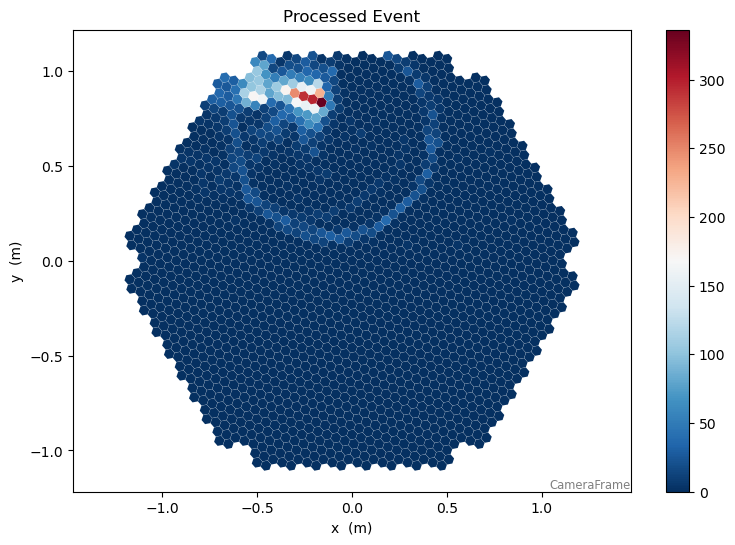

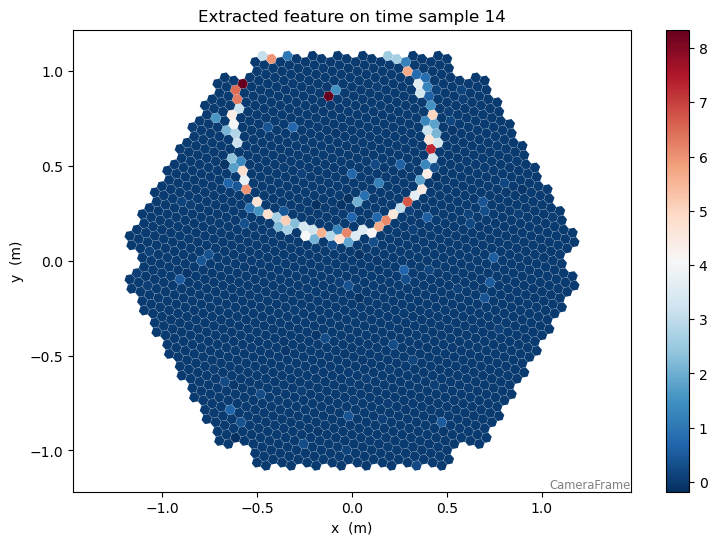

In [95]:
##
##
## Full pipeline for extracting ring and deleting shower based on time sample separation:
## 11 sample ring appears, 18 sample only shower remains
##
##
##



# Event extraction
run_number = 2
event_number = 223
tel_number = 2
filename = f'/Users/vdk/sim_run_folder/output_prod_v12/corsika_theta_28.4_az_182.75_run{run_number}.simtel.gz'
source = EventSource(filename, max_events=9000)
event_iterator = iter(source)
for i,j in enumerate(event_iterator):
    if i == event_number:
        event = j
        break

# Building appropriate image for this event
plt.figure(figsize = (9,6))
camgeom = source.subarray.tel[1].camera.geometry
title="Processed Event"
disp = CameraDisplay(camgeom,title=title, norm = 'lin', autoscale = False, allow_pick = True)
#disp.image = event.r1.tel[teln].waveform[:,11]
#disp.image = working_arr
disp.image = event.simulation.tel[tel_number].true_image
disp.cmap = plt.cm.RdBu_r
disp.add_colorbar()
disp.set_limits_percent(95)
#plt.savefig(f"/Users/vdk/ProcessedEvent_event{j.index.event_id}")


# Creating waveform array for working with him, on 18 sample as usual we see only contamination
working_arr = event.r1.tel[2].waveform[:,18].copy()
leng = 0
cont_arr = np.zeros(1855)
ring_arr = []

# If its not contamination, we assign value of 100 to it
for i,j in enumerate(working_arr):
    if working_arr[i] < 4:
        cont_arr[i] = 100
        leng += 1
        working_arr[i] = 0
    else:
        cont_arr[i] = working_arr[i]

# If its not a ring we assign value of 100 to it, ring became visually distinguishable on 11 sample
working_arr = event.r1.tel[2].waveform[:,11].copy()
for i,j in enumerate(working_arr):
    if working_arr[i] > 0.35:
        ring_arr.append(100)
    else:
        ring_arr.append(working_arr[i])
    
#   
#Lets create a mask to cut shower pixels from ring mask
#

# Index of shower pixels
shower_ind = np.zeros(1855)
# Index of ring pixels
ring_ind = np.zeros(1855)

for i,j in enumerate(cont_arr):
    if j == 100:
        shower_ind[i] = i
        
    
for i,j in enumerate(ring_arr):
    if j == 100:
        ring_ind[i] = 0
    else:
        ring_ind[i] = i



time_s = 14
# time sample
image_arr = event.r1.tel[tel_number].waveform[:,time_s].copy() # array where we will preserve extracted feature
#working_arr = event.r1.tel[2].waveform[:,time_s].copy()

# Extracting of the ring
for i,j in enumerate(shower_ind):
    if (cont_arr[i] != 100 and ring_ind[i] == 0) or shower_ind[i] == 0 or ring_ind[i] != 0:
        #image_arr[i] = min(event.r1.tel[tel_number].waveform[:,time_s].copy())
        image_arr[i] = 0

plt.figure(figsize = (9,6))
camgeom = source.subarray.tel[1].camera.geometry
title=f"Extracted feature on time sample {time_s}"
disp = CameraDisplay(camgeom,title=title, norm = 'lin', autoscale = False, allow_pick = True)
disp.image = image_arr
disp.cmap = plt.cm.RdBu_r
disp.add_colorbar()
disp.set_limits_percent(95)

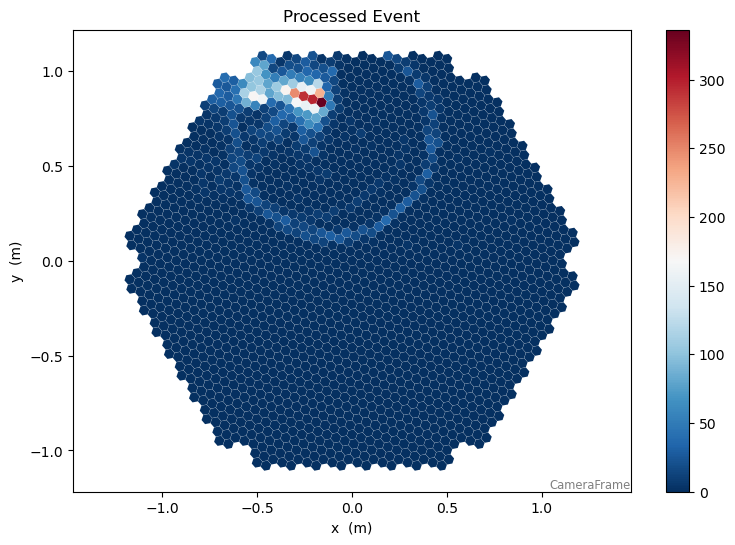

In [97]:
plt.figure(figsize = (9,6))
camgeom = source.subarray.tel[1].camera.geometry
title="Processed Event"
disp = CameraDisplay(camgeom,title=title, norm = 'lin', autoscale = False, allow_pick = True)
#disp.image = event.r1.tel[tel_number].waveform[:,18]
#disp.image = shower_arr
disp.image = event.simulation.tel[tel_number].true_image
disp.cmap = plt.cm.RdBu_r
disp.add_colorbar()
disp.set_limits_percent(95)

shower_arr = []
working_arr = event.r1.tel[2].waveform[:,18].copy()

for i,j in enumerate(working_arr):
    if working_arr[i] > 5:
        shower_arr.append(100)
    else:
        shower_arr.append(working_arr[i])
        
shower_mask = np.zeros(1855, dtype = bool)

for i,j in enumerate(shower_arr):
    if j == 100:
        shower_mask[i] = True
    else:
        shower_mask[i] = False
        

In [98]:
shower_arr = event.r0.tel[tel_number].waveform[1][shower_mask]

In [99]:
for_hist = []
check = 0
peak_arr = np.empty(shower_arr.shape[0], dtype = int)
np.argmax(shower_arr, axis = 1, out = peak_arr)
proton_2223 = peak_arr.copy()

In [154]:
proton_9222

array([19, 20, 19, 19, 20, 19, 19, 19, 17, 19, 20, 18, 20, 19, 18, 19, 19,
       19, 18, 19, 20, 17, 19, 19])

In [39]:
ring_mask = np.array(image_arr, dtype=bool)
ring_mask

array([False, False, False, ..., False, False, False])

In [40]:
new_arr = event.r0.tel[tel_number].waveform[1][~ring_mask]

In [41]:
new_arr.shape[0]

1678

In [42]:
for_hist = []
check = 0
peak_arr = np.empty(new_arr.shape[0], dtype = int)
np.argmax(new_arr, axis = 1, out = peak_arr)
proton_9222 = peak_arr.copy()

In [4]:
ring_9222 = [13, 14, 15, 15, 15, 15, 15, 16,  3, 39, 15, 14, 14,  0, 12, 13, 36,
       15, 14, 13, 14, 13, 13, 14, 12,  2, 14, 14, 15, 15, 15, 34, 14, 15,
       13, 14, 26,  9,  5, 15, 15, 14, 14, 14, 13, 14, 39, 15, 15, 14, 13,
       16, 14, 14, 32, 14, 15, 14, 15, 14, 14,  0, 15, 14, 16]

ring_2223 = [ 0, 14,  7, 15, 15, 14, 23, 17, 10, 10, 14, 13, 14, 14, 16, 13, 14,
       17, 14, 14, 16, 10, 22, 14, 38,  0, 14, 26,  0, 15,  3, 13, 12, 19,
       14, 14, 14,  3, 11, 14, 14, 15, 16, 13, 19,  7, 27, 11, 16, 14, 18,
       15,  0,  9, 15, 14, 32,  6, 28, 15, 17, 32, 13, 10,  6, 25, 15, 37,
       13, 26, 16, 26, 15, 30, 12,  1, 14, 13, 31, 27, 19, 15, 15, 20, 19,
       21, 33, 16, 15,  5, 36, 12, 38, 22, 18, 15, 12, 14, 14, 12,  4,  7,
       18, 25, 38, 26, 14, 14, 21, 16, 14, 15, 32, 31,  2,  0, 14, 14,  1,
        1, 19, 15,  3, 13, 22, 31, 25, 34, 17, 16, 15, 16,  9, 15, 34, 12,
        4, 13, 18, 32,  3, 15, 14, 31, 13, 17, 28,  9, 13, 39, 22, 15, 16,
       14, 15, 31,  0, 18,  3, 14, 19, 15, 16,  7, 15, 25, 12, 26, 15,  1,
       14, 28, 16, 15, 14, 13,  8, 11,  9,  2, 10, 13, 16]

proton_2223 = [19, 19, 18, 17, 17, 18, 17, 17, 17, 17, 17, 17, 18, 16, 17, 16, 17,
       18, 16, 18, 16, 17, 18, 17, 17, 18, 17, 16, 17, 16, 17, 17, 17, 17,
       16, 18, 15, 16, 16, 18, 17, 16]
proton_9222 = [20, 19, 20, 20, 22, 22, 22, 20, 19, 19, 21, 22, 20, 19, 20, 34, 19,
       19, 19, 17, 19, 19, 20, 18, 20, 19, 19, 20, 19, 18, 19, 19, 18, 21,
       19, 18, 19, 20, 17, 19, 19, 21]

proton_2438 = [16, 17, 16, 17, 16, 16, 17, 17, 17, 17, 18, 17, 19, 18, 18, 17, 17,
       20, 18, 18, 20, 19, 18, 16, 18, 17, 19, 20, 21, 18, 20, 19, 19, 18,
       19, 20, 18, 20, 19, 20, 18, 17, 18, 19, 20, 19, 17, 17, 18, 17, 18,
       16, 16, 17, 17, 18]

ring_2438 = [15, 15, 14, 15, 15, 15, 15, 14, 14, 13, 14, 13, 14, 14, 13, 13, 14,
       13, 15, 16, 14, 14, 15, 13, 14, 15, 14, 14, 15, 15, 13, 15, 15, 13,
       14, 14, 18, 14, 13, 14, 15, 14, 13, 14, 39, 13, 17, 14, 13, 14, 14,
       15, 14, 14, 12, 15, 13, 14, 14, 14, 13, 15, 13, 14, 15, 12, 15, 14,
       23, 14]

proton_25051 = [18, 17, 17, 17, 19, 20, 19, 20, 21, 20, 18, 19, 19, 21, 21, 21, 19,
       19, 20, 20, 20, 20, 19, 20, 19, 19, 20, 18, 19, 20, 19, 18, 18, 19,
       19, 19, 19]
ring_25051 = [14, 14, 15, 13, 14, 14, 12, 13, 14, 13, 13, 14, 15, 14, 15, 14, 14,
       13, 14, 14, 14, 14, 13, 15, 14, 15, 14, 14, 14, 14, 13, 15, 13, 13,
       14, 12, 14, 16, 14, 13, 16, 13, 14, 15, 13, 15, 13, 15, 13, 15, 15,
       14, 14, 13, 14, 14, 14, 13, 22, 15, 13, 13, 16, 15, 14,  7, 30, 14,
       13, 13, 11, 13, 14, 15, 15, 13, 15, 14, 13, 14, 13, 14, 13, 15]

# event not separated in time
# Separated by double cut (shower on sample 20 intensity > 0.9, ring on sample 12 intensity > 1.2)
# then pixels of shower was subtracted from ring pixels
#
ring_14406 = [13, 13, 13, 16, 20, 13, 12, 14, 15, 15, 14, 13, 13, 14, 12, 15, 14,
       14, 15, 13, 14, 15, 24, 15, 14, 12, 15, 14, 14, 10, 14, 13, 15, 14,
       17, 15, 14, 14, 13, 15, 14, 14, 15, 15, 15, 14, 13, 14, 13, 15, 14,
       14, 13, 13, 15, 10, 14, 15, 13, 13, 15, 15, 17, 16, 13, 16, 14, 14,
       16, 13, 13, 15, 15, 17, 14, 15, 15, 14, 14,  4, 16, 15, 15, 14, 15,
       14, 14, 15, 14, 15, 19, 13, 14, 12, 15, 15, 13, 14, 16, 39, 14, 15,
       14, 15, 14, 14, 12, 13, 14, 27]

proton_14406 = [15, 16, 15, 15, 15, 20, 15, 15, 16, 15, 18, 15, 14, 15, 16, 16, 14,
       14, 15, 15, 37, 14, 15, 15, 14, 14]

#
#

ring_22126 = [16, 15, 14, 14, 14, 14, 13, 14, 14, 15, 16, 14, 15, 13, 13, 14, 15,
       29, 15, 13, 14, 23, 13, 14, 15, 15, 16, 14, 13, 15, 15, 14, 13, 13,
       23, 38, 15, 15, 15, 14, 11, 14, 13, 13, 13, 14, 13, 15, 15, 14, 13,
       15, 15, 29, 15, 15, 13, 13, 14, 13, 14, 15, 12, 15, 14, 15, 15, 15,
       14, 14, 10, 13, 15, 15, 15, 14, 14, 34, 39, 14]

proton_22126 = [23, 20, 25, 24, 19, 20, 24,  5, 20, 21, 21, 24, 22, 22, 21, 22, 20,
       23, 20, 22, 21, 23, 24, 24, 22, 23, 20, 19, 21, 21, 22, 20, 23, 23,
       21, 22, 21, 21, 21, 23, 22, 21, 21, 22, 23, 17, 15,  4, 21, 20, 20,
       20, 21, 20, 20, 20, 20, 25, 20, 22, 20, 21, 21, 21, 21, 21, 23]


ring_22365 = [15, 12, 14, 12, 13, 16, 14, 14, 14, 14, 14, 14, 13, 14, 14, 14, 14,
       13, 13, 14, 13, 13, 14, 13, 14, 14, 14, 13, 14, 13, 14, 12, 14, 15,
       24, 14, 15, 13, 13, 14, 13, 13, 19, 13, 14, 13, 15, 13, 14, 13, 12,
       14, 15, 14, 14, 12, 14, 14, 13, 38, 15, 14, 14, 13, 13, 14, 13, 13,
       11, 13, 12, 12, 14, 13, 14, 28, 13, 14, 35, 14, 13, 15, 13, 12, 15,
       28, 15, 12, 11, 12, 13,  8, 13, 13]

proton_22365 = [22, 20, 22, 19, 19, 23, 20, 21, 18, 19, 21, 22, 24, 22, 21, 22, 20,
       19, 14, 24, 24, 21, 22, 20, 21, 20, 22, 20, 23, 21, 22, 20, 23, 21,
       20, 22, 21, 11, 20, 19, 20, 19, 38, 20, 19, 20, 21, 22, 21, 19, 19,
       19, 20, 13, 20, 20, 21, 21, 21, 20, 23, 21, 22]

ring_32298 = [6, 25, 14, 12, 14, 14, 15, 14, 15, 15,  9, 17, 23,  1, 13, 11, 15,
       12, 14, 14, 16, 39, 13, 15, 12, 13,  0, 15, 13, 13, 15, 13,  3, 16,
       11, 13, 14, 15, 29, 14, 14, 25, 14,  5, 14, 11, 14, 19, 14, 14, 28,
       14, 14, 14, 16, 14, 14, 14, 13, 14, 13]

proton_32298 = [11, 19, 19, 14, 13, 15, 14, 24, 37, 15, 13, 17, 18, 16, 17, 18, 17,
       15, 17, 17, 17,  1, 19, 10,  7, 16,  7, 14, 16, 22, 13, 14]

ring_35219 = [29, 15, 14, 11, 13, 13, 16, 13, 13, 14, 13, 13, 14, 12, 13, 13, 15,
       12, 12, 14, 14, 16, 14, 14, 14, 14, 14, 14, 33, 14, 14, 15, 13, 17,
       14, 14,  3, 15, 14, 15, 35, 14, 14, 14, 13, 13, 14, 15, 13, 13, 14,
       14, 14, 19, 31, 12, 13, 14, 13, 15, 13, 15, 14, 14]

proton_35219 = [17, 16, 17, 17, 17, 15, 15, 18, 18, 13, 15, 16, 13, 15, 15]

ring_28000 = [15, 15, 15, 14, 15, 15,  8,  2, 15, 13, 11, 15, 39, 15, 12, 14, 15,
       15, 12, 15, 14, 14, 14, 14, 13, 15, 15, 14, 15, 14, 15, 14, 14, 14,
       15, 11, 14, 14, 15, 14, 14, 17, 17, 14, 13, 14, 15, 14, 16, 13, 12,
       14, 15, 14, 12, 13, 15, 15, 14, 15, 15, 17, 15, 14, 13, 21, 13, 16,
       14, 14, 15, 14, 13, 13, 13, 14, 13, 15, 14, 13,  4, 14, 12, 14, 16,
       14, 14, 14, 10, 15, 24, 15, 14, 13,  5, 14, 13, 12, 16, 14, 11, 13,
       24]

proton_28000 = [19, 24, 21, 20, 21, 20, 22, 21, 22, 21,  4, 22, 21, 19, 19, 18, 21,
       22, 18, 16,  8, 24, 23, 21, 20, 20, 18, 20, 23, 21, 21, 19, 21,  2,
       22, 19, 21, 20]

ring_35298 = [13, 14, 14, 15, 14, 12, 15, 14, 13, 34, 14, 14, 14, 12, 14, 35, 14,
       14, 14, 13, 13, 25, 15, 13, 15, 14,  0, 13, 14, 13, 15, 12, 15, 13,
       13, 13, 13, 12, 13, 14, 13, 13, 14, 14, 15, 13,  3, 14, 13, 14, 13,
       15]

proton_35298 = [14, 14,  5, 36, 15, 19, 18, 15, 10, 21, 21, 18, 19, 19, 20, 19, 19,
       18, 19, 22, 31, 20, 24]


###
###
### Fitted Events

proton_8234 = [ 0, 19, 20,  5, 20, 21, 21, 21, 19, 21, 20, 19, 21, 19, 19, 19, 20,
                20, 16, 21, 18, 21, 22, 18, 18, 19, 20, 20,  0, 20, 19, 20, 18, 20]

ring_8234 = [13, 14, 12, 17, 15, 13, 12, 14, 14, 16, 15, 13, 14, 15, 13, 14, 14,
        0, 13, 15, 13, 15, 13, 14, 14, 15, 14, 13, 15, 13, 16, 15, 14, 15,
       12,  9, 14, 15, 14, 15, 13, 14, 13, 15, 14, 15, 14, 14, 14, 14, 11,
       14,  2, 14, 15, 15, 16, 13, 14, 15, 12]


proton_8448 = [24, 21, 19, 18, 20, 22, 22, 22, 21, 22, 22, 22, 19, 20, 20, 19, 20,
       19, 19, 19, 20, 20, 19]

ring_8448 = [14, 15, 15,  8, 11, 13, 14, 24, 15, 14, 12, 15, 13, 17, 14, 11, 13,
       15, 20, 35, 16, 14, 17, 17, 14, 13, 15, 15, 14, 13, 13, 15, 13, 14,
       15, 15, 13, 16, 14, 13, 14, 15, 12, 15, 14, 15, 11, 17, 14, 13, 13,
       13, 16, 15, 14, 14, 14, 14, 15]

proton_9404 = [22, 22, 19, 22, 20, 21, 20, 21, 22, 20,  3, 19, 21, 23, 20, 19, 23,
       21, 19, 21, 23, 20, 18, 21, 23]

ring_9404 = [12, 14, 13, 12, 13, 13, 14, 24, 14, 12, 14, 13,  4, 13, 13, 12, 14,
       14, 21, 13, 13, 14, 13, 13, 14, 18, 14, 13, 15, 16, 13, 14, 18, 14,
       35, 14, 12, 13, 14, 15, 13, 23, 15, 14, 31, 14, 13, 14, 14, 13, 24,
       14, 15, 14, 13, 13, 14, 13,  9, 12, 11,  9, 13, 14, 13, 30, 13, 15,
       14, 12, 14, 12, 15, 15, 13, 22, 16, 15, 22, 12, 14, 13, 14, 13, 14,
       13, 15, 14, 17, 14, 15, 15, 13, 13, 12, 12, 15, 29, 14, 13, 16, 15,
       15, 15, 13]

ring_9433 = [31, 13, 14, 15,  8, 12, 14, 14, 13, 13, 14, 14, 13, 14, 15, 32, 14,
       14, 13, 15, 12, 15, 15, 12, 14, 14, 14, 14, 17, 13, 14, 14, 14, 13,
       14,  7, 14, 15, 12, 14, 14, 15, 13, 14, 14, 14, 33, 15, 13, 14, 12,
       15, 13, 13, 15, 13, 14, 14, 13, 14, 16, 14, 12, 15, 23, 12, 17, 14,
       13, 23, 15]

proton_9433 = [33, 21, 19, 20, 19, 19, 19, 18, 20, 20, 21, 20, 11, 20, 21, 21, 18,
       19, 20]


ring_27374 = [12, 15, 24, 14, 15, 13,  8, 13, 13, 15, 13, 39, 11, 14, 30, 14, 14,
       12, 14, 21, 14, 14, 13, 14, 14, 16, 13, 12, 13, 14, 15, 15, 15, 14,
       24, 15, 13, 16, 14, 14, 14, 14, 15,  0, 13, 14, 14, 14, 13, 14, 15,
       14, 14, 14, 12, 15, 14, 12, 12, 15, 14, 14, 13, 15, 14, 15, 15, 11,
       14, 14, 14, 14, 14, 13, 12, 13,  1, 14, 23, 13, 14, 36, 14, 22, 13,
       14, 15, 11, 25, 14, 16, 26,  9, 14, 15, 13, 13, 14, 13, 12, 14, 13,
       14]
proton_27374 = [18, 16, 17, 17, 17, 17, 31, 19, 16,  1, 13]

ring_28328 = [13, 14, 14, 13, 16, 14, 17, 15, 13, 13, 14, 15, 14, 15, 15, 14, 16,
       16, 14, 14, 12, 13, 15, 13, 11, 23, 14, 15, 16, 33, 13, 14, 14, 15,
       13, 13, 15, 13,  1, 15, 15, 14, 15, 14, 22, 15, 13, 13, 15, 15, 15,
       15, 15, 16,  7, 27, 12, 16, 14, 22, 13, 15, 13, 13, 14, 12,  1, 15,
       15,  0, 14, 15, 13, 16, 13, 14, 14,  7, 15, 36, 14, 14, 13, 15, 27,
       14, 13, 14, 15, 13, 14,  2, 14, 12, 15, 26, 19, 10, 13, 15, 13, 12,
       26, 14,  0, 22]
proton_28328 = [ 5, 36, 19, 18, 10, 21, 21, 18, 19, 19, 20, 19, 19, 18, 19, 22, 31,
       20, 24]
###
###
###


In [168]:
ring_stack = np.concatenate((ring_2223, ring_9222), axis=None)
#ring_stack.append(ring_9222)
#ring_stack.append(ring_2223)
proton_stack = np.concatenate((proton_2223, proton_9222), axis=None)
#proton_stack.append(proton_9222)
#proton_stack.append(proton_2223)

Text(0.5, 1.0, 'Rings and proton peak time hist for 2223 and 9222 events')

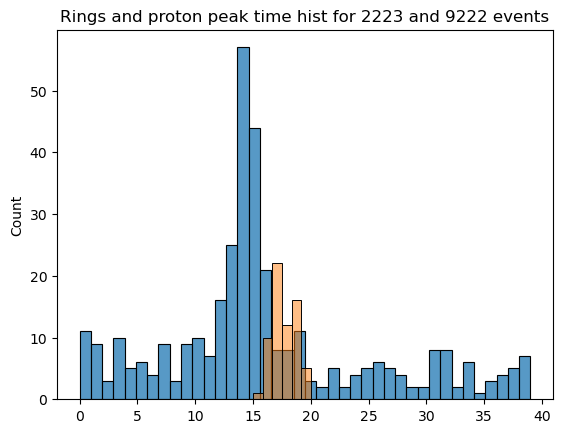

In [169]:
histplot(ring_stack, bins = 40)
histplot(proton_stack, bins = 6,alpha = 0.5)
plt.title("Rings and proton peak time hist for 2223 and 9222 events")

In [115]:
max(ring_stack)

39

In [724]:
##
##
## Full pipeline for extracting ONLY ring
##
##
##



# Event extraction
run_number = 16
event_number = 379
tel_number = 3
filename = f'/Users/vdk/sim_run_folder/output_prod_v12/corsika_theta_28.4_az_182.75_run{run_number}.simtel.gz'
source = EventSource(filename, max_events=9000)
event_iterator = iter(source)
for i,j in enumerate(event_iterator):
    if i == event_number:
        event = j
        break





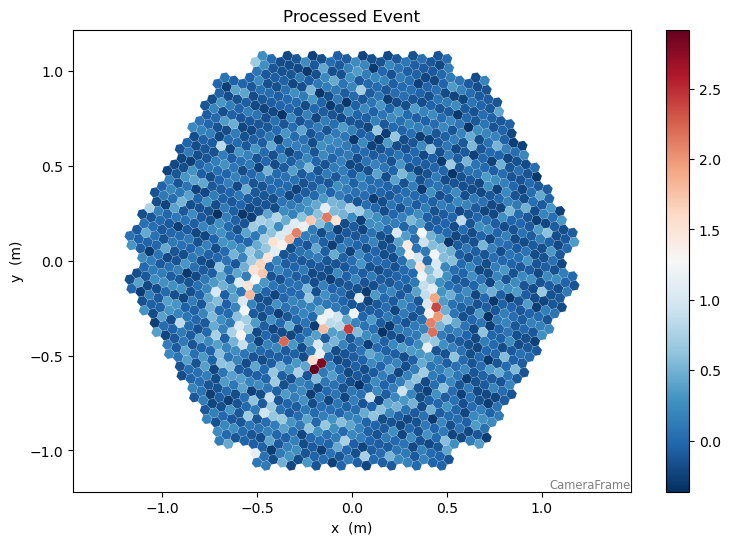

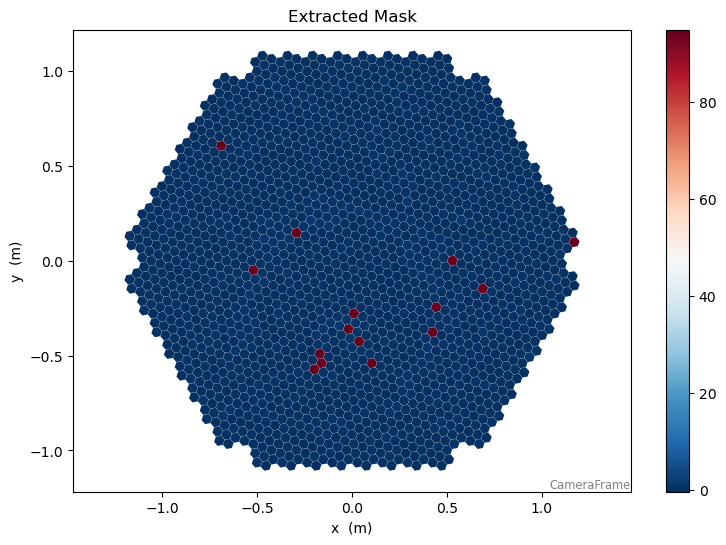

In [730]:
# Building appropriate image for this event
plt.figure(figsize = (9,6))
camgeom = source.subarray.tel[1].camera.geometry
title="Processed Event"
disp = CameraDisplay(camgeom,title=title, norm = 'lin', autoscale = False, allow_pick = True)
disp.image = event.r1.tel[tel_number].waveform[:,20]
#disp.image = proton_arr
#disp.image = event.simulation.tel[tel_number].true_image
disp.cmap = plt.cm.RdBu_r
disp.add_colorbar()
disp.set_limits_percent(95)
#plt.savefig(f"/Users/vdk/ProcessedEvent_event{j.index.event_id}")



ring_arr = []
# If its not a ring we assign value of 100 to it, ring became visually distinguishable on 11 sample
working_arr = event.r1.tel[tel_number].waveform[:,12].copy()
for i,j in enumerate(working_arr):
    if working_arr[i] > 1 and working_arr[i] < 60:
        ring_arr.append(100)
    else:
        ring_arr.append(working_arr[i])


proton_arr = []
working_arr = event.r1.tel[tel_number].waveform[:,22].copy()
for i,j in enumerate(working_arr):
    if working_arr[i] > 1 and working_arr[i] < 50:
        proton_arr.append(100)
    else:
        proton_arr.append(working_arr[i])
        
        
        
        
# Building appropriate image for this event
plt.figure(figsize = (9,6))
camgeom = source.subarray.tel[1].camera.geometry
title="Extracted Mask"
disp = CameraDisplay(camgeom,title=title, norm = 'lin', autoscale = False, allow_pick = True)
#disp.image = event.r1.tel[teln].waveform[:,11]
disp.image = proton_arr
#disp.image = event.simulation.tel[tel_number].true_image
disp.cmap = plt.cm.RdBu_r
disp.add_colorbar()
disp.set_limits_percent(95)
#plt.savefig(f"/Users/vdk/ExtractedMask_event{run_number}_{str(0)}_{event_number}")

In [317]:
np.count_nonzero(muon_mask[~proton_mask])

0

In [704]:
muon_mask = np.zeros(1855, dtype = bool)

bad_pix = []

for i,j in enumerate(proton_arr):
    if j == 100:
        bad_pix.append(i)
        
bad_pix_2 = []

for i,j in enumerate(ring_arr):
    if j == 100:
        bad_pix_2.append(i)
        
for i,j in enumerate(ring_arr):
    if j == 100 and i not in bad_pix:
    #if j == 100:
        muon_mask[i] = True
    else:
        muon_mask[i] = False

proton_mask = np.zeros(1855, dtype = bool)

for i,j in enumerate(proton_arr):
    if j == 100 and i not in bad_pix_2:
        proton_mask[i] = True
    else:
        proton_mask[i] = False


        
print("muon mask = ", np.count_nonzero(muon_mask))
print("proton mask = ", np.count_nonzero(proton_mask))



muon mask =  52
proton mask =  19


In [705]:
#true_muon_mask = muon_mask[~proton_mask]
event_value = 35298
protons = event.r0.tel[tel_number].waveform[1][proton_mask]
muons = event.r0.tel[tel_number].waveform[1][muon_mask]

peak_arr_p = np.empty(protons.shape[0], dtype = int)
peak_arr_m = np.empty(muons.shape[0], dtype = int)

np.argmax(protons, axis = 1, out = peak_arr_p)
np.argmax(muons, axis = 1, out = peak_arr_m)
proton_35298 = peak_arr_p.copy()
ring_35298 = peak_arr_m.copy()

In [706]:

print(np.count_nonzero(eval(f'proton_{event_value}')))
print(np.count_nonzero(eval(f'ring_{event_value}')))


19
51


1471 572


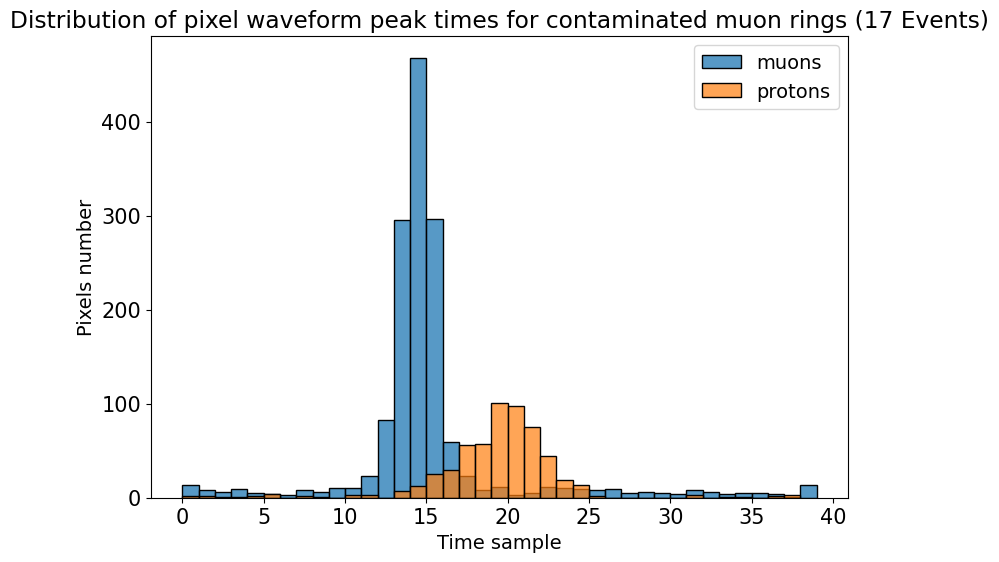

In [6]:
ring_stack = np.concatenate((ring_2223, ring_9222,ring_2438, ring_25051, ring_14406, ring_22126, ring_22365, ring_32298, ring_35219, ring_8234, ring_8448, ring_9404, ring_9433, ring_27374, ring_28328, ring_28000, ring_35298), axis=None)
proton_stack = np.concatenate((proton_2223, proton_9222,proton_2438, proton_25051, proton_14406, proton_22126, proton_22365, proton_32298, proton_35219, proton_8234, proton_8448, proton_9404, proton_9433, proton_27374, proton_28328, proton_28000, proton_35298), axis=None)
plt.figure(figsize=(9,6))
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15)
plt.rcParams.update({'font.size': 14})
histplot(ring_stack, binwidth = 1, label = 'muons')
histplot(proton_stack, binwidth=1,alpha = 0.7, label = 'protons')
plt.title("Distribution of pixel waveform peak times for contaminated muon rings (17 Events)")
plt.xlabel("Time sample")
plt.ylabel("Pixels number")
plt.legend()
#plt.savefig("/Users/vdk/ImagePurgatorium/TimeSamplesHistogram.png")
print(len(ring_stack), len(proton_stack))

1471 572


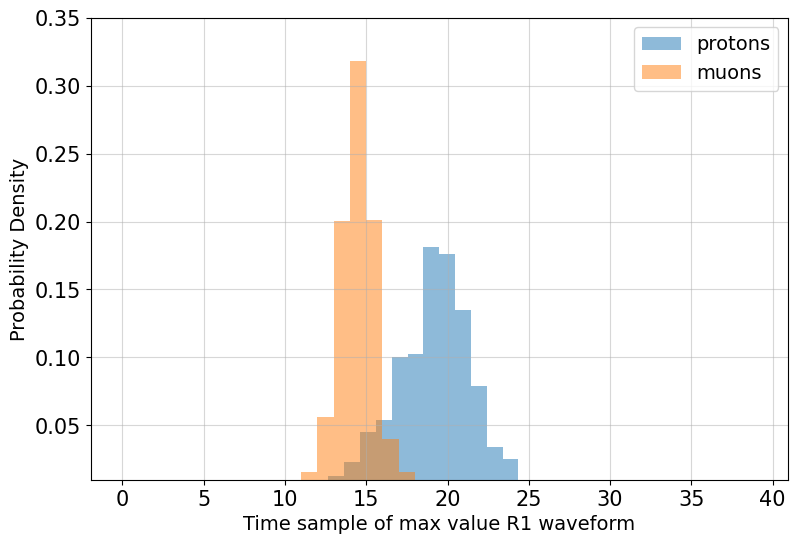

In [20]:
ring_stack = np.concatenate((ring_2223, ring_9222,ring_2438, ring_25051, ring_14406, ring_22126, ring_22365, ring_32298, ring_35219, ring_8234, ring_8448, ring_9404, ring_9433, ring_27374, ring_28328, ring_28000, ring_35298), axis=None)
proton_stack = np.concatenate((proton_2223, proton_9222,proton_2438, proton_25051, proton_14406, proton_22126, proton_22365, proton_32298, proton_35219, proton_8234, proton_8448, proton_9404, proton_9433, proton_27374, proton_28328, proton_28000, proton_35298), axis=None)
plt.figure(figsize=(9,6))
#matplotlib.rc('xtick', labelsize=15) 
#matplotlib.rc('ytick', labelsize=15)
#lt.rcParams.update({'font.size': 14})
plt.hist(proton_stack, density = True, alpha = 0.5, bins = 39,label = 'protons')
plt.hist(ring_stack, density = True, alpha = 0.5,bins =39,label = 'muons')
#plt.title("Distribution of pixel waveform peak times for contaminated muon rings (17 Events)")
plt.xlabel("Time sample of max value R1 waveform")
plt.ylabel("Probability Density")
plt.legend()
plt.grid(alpha = 0.5)
plt.ylim(0.01,0.35)
#plt.savefig("/Users/vdk/ImagePurgatorium/TimeSamplesHistogram.png")
print(len(ring_stack), len(proton_stack))

In [710]:
eval(f'proton_{event_value}')

array([ 5, 36, 19, 18, 10, 21, 21, 18, 19, 19, 20, 19, 19, 18, 19, 22, 31,
       20, 24])

Text(0.5, 1.0, 'Peak time histogram for event_25051')

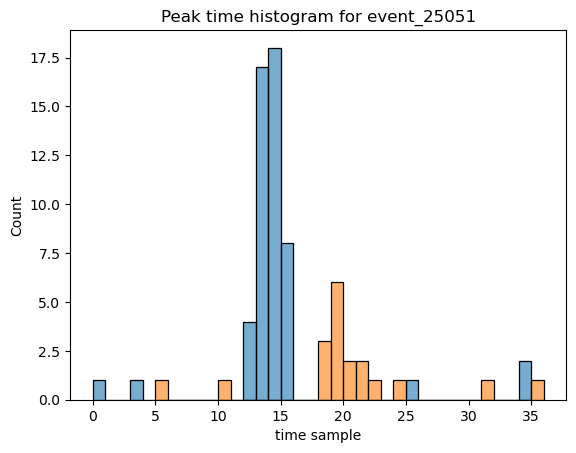

In [708]:
histplot(eval(f'ring_{event_value}'), binwidth = 1, alpha = 0.6)
histplot(eval(f'proton_{event_value}'), binwidth=1,alpha = 0.6)
plt.xlabel("time sample")
plt.title(f"Peak time histogram for event_{25051}")

In [525]:
proton_8234

array([ 0, 19, 20,  5, 20, 21, 21, 21, 19, 21, 20, 19, 21, 19, 19, 19, 20,
       20, 16, 21, 18, 21, 22, 18, 18, 19, 20, 20,  0, 20, 19, 20, 18, 20])

In [526]:
ring_8234

array([13, 14, 12, 17, 15, 13, 12, 14, 14, 16, 15, 13, 14, 15, 13, 14, 14,
        0, 13, 15, 13, 15, 13, 14, 14, 15, 14, 13, 15, 13, 16, 15, 14, 15,
       12,  9, 14, 15, 14, 15, 13, 14, 13, 15, 14, 15, 14, 14, 14, 14, 11,
       14,  2, 14, 15, 15, 16, 13, 14, 15, 12])